In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [7]:
dataset_path = "/kaggle/input/jo-clean-data"
df = pd.read_csv(f"{dataset_path}/country_medals_ml (1).csv")

print(df.head())

   year country_name medal_type  count  past_medals  avg_last_3  delta
0  2008  Afghanistan     BRONZE      1          0.0    0.000000    0.0
1  2012  Afghanistan     BRONZE      1          1.0    0.000000    0.0
2  1984      Algeria     BRONZE      2          2.0    0.000000    0.0
3  1992      Algeria     BRONZE      1          2.0    0.000000   -1.0
4  1992      Algeria       GOLD      1          3.0    1.333333    0.0


**Transformer le CSV pour avoir une colonne par type de médaille**

In [8]:
# Pivot pour transformer medal_type en colonnes
df_pivot = df.pivot_table(
    index=['year', 'country_name', 'past_medals', 'avg_last_3', 'delta'],
    columns='medal_type',
    values='count',
    fill_value=0
).reset_index()

# Renommer les colonnes si besoin
df_pivot = df_pivot.rename(columns={'GOLD':'Gold','SILVER':'Silver','BRONZE':'Bronze'})

print(df_pivot.head())

medal_type  year country_name  past_medals  avg_last_3  delta  Bronze  Gold  \
0           1896    Australia         12.0    0.000000    0.0     0.0   2.0   
1           1896      Austria          2.0    0.000000    0.0     0.0   2.0   
2           1896      Austria          4.0    1.666667   -1.0     0.0   0.0   
3           1896      Austria        566.0    0.000000    0.0     2.0   0.0   
4           1896      Denmark          3.0    0.000000   -2.0     0.0   1.0   

medal_type  Silver  
0              0.0  
1              0.0  
2              1.0  
3              0.0  
4              0.0  


**Préparer les features et targets pour le ML**

In [9]:
features = ['past_medals', 'avg_last_3', 'delta']

In [10]:
# Entraîner un modèle séparé pour chaque type de médaille
rf_gold = RandomForestRegressor(n_estimators=200, random_state=42)
rf_silver = RandomForestRegressor(n_estimators=200, random_state=42)
rf_bronze = RandomForestRegressor(n_estimators=200, random_state=42)

rf_gold.fit(df_pivot[features], df_pivot['Gold'])
rf_silver.fit(df_pivot[features], df_pivot['Silver'])
rf_bronze.fit(df_pivot[features], df_pivot['Bronze'])

RandomForestRegressor(n_estimators=200, random_state=42)

In [11]:
# Fonction pour prédire pour un pays donné
def predict_medals(country_name):
    country = df_pivot[df_pivot['country_name']==country_name].iloc[-1]  # dernière année disponible
    X_country = pd.DataFrame([country[features]])
    
    pred_gold = round(rf_gold.predict(X_country)[0])
    pred_silver = round(rf_silver.predict(X_country)[0])
    pred_bronze = round(rf_bronze.predict(X_country)[0])
    
    return pred_gold, pred_silver, pred_bronze

In [12]:
# Prédiction pour la France
gold_fr, silver_fr, bronze_fr = predict_medals('France')
print("\nPrédiction médailles France JO 2024 :")
print(f"Or : {gold_fr}, Argent : {silver_fr}, Bronze : {bronze_fr}")


Prédiction médailles France JO 2024 :
Or : 1, Argent : 5, Bronze : 1


In [13]:
# ----------------------------
# Prédiction pour tous les pays
countries = df_pivot['country_name'].unique()
predictions = []

for country in countries:
    g, s, b = predict_medals(country)
    predictions.append({'country_name': country, 'Gold': g, 'Silver': s, 'Bronze': b, 'Total': g+s+b})

# Convertir en DataFrame
df_pred = pd.DataFrame(predictions)

# Top 25 pays par total de médailles prédit
top25 = df_pred.sort_values('Total', ascending=False).head(25)
print("\nTop 25 pays - prédiction médailles JO 2024 :")
print(top25)


Top 25 pays - prédiction médailles JO 2024 :
                             country_name  Gold  Silver  Bronze  Total
74   German Democratic Republic (Germany)     7      35       1     43
55                           Soviet Union     0      37       2     39
106                          Unified Team     0       0      25     25
73            Federal Republic of Germany     2      14       2     18
24                     Russian Federation     2      13       0     15
151                                   ROC     3       9       0     12
4                                 Germany     1       8       1     10
10               United States of America     1       9       0     10
13                                 Canada     1       7       1      9
16                                  Italy     1       5       2      8
108                            Kazakhstan     0       0       8      8
19                                 Norway     1       7       0      8
3                              

**Calculer les métriques**

In [20]:
# ----------------------------
# Vraies valeurs (Gold / Silver / Bronze)
y_true_gold   = df_pivot['Gold']
y_true_silver = df_pivot['Silver']
y_true_bronze = df_pivot['Bronze']

# ----------------------------
# Prédictions avec les modèles entraînés
y_pred_gold   = rf_gold.predict(df_pivot[features])
y_pred_silver = rf_silver.predict(df_pivot[features])
y_pred_bronze = rf_bronze.predict(df_pivot[features])

# ----------------------------
# Calcul RMSE et MAE
rmse_gold   = np.sqrt(mean_squared_error(y_true_gold, y_pred_gold))
rmse_silver = np.sqrt(mean_squared_error(y_true_silver, y_pred_silver))
rmse_bronze = np.sqrt(mean_squared_error(y_true_bronze, y_pred_bronze))

mae_gold   = mean_absolute_error(y_true_gold, y_pred_gold)
mae_silver = mean_absolute_error(y_true_silver, y_pred_silver)
mae_bronze = mean_absolute_error(y_true_bronze, y_pred_bronze)

print(f"RMSE - Gold: {rmse_gold:.2f}, Silver: {rmse_silver:.2f}, Bronze: {rmse_bronze:.2f}")
print(f"MAE  - Gold: {mae_gold:.2f}, Silver: {mae_silver:.2f}, Bronze: {mae_bronze:.2f}")

RMSE - Gold: 1.90, Silver: 1.50, Bronze: 1.62
MAE  - Gold: 0.90, Silver: 0.84, Bronze: 0.89


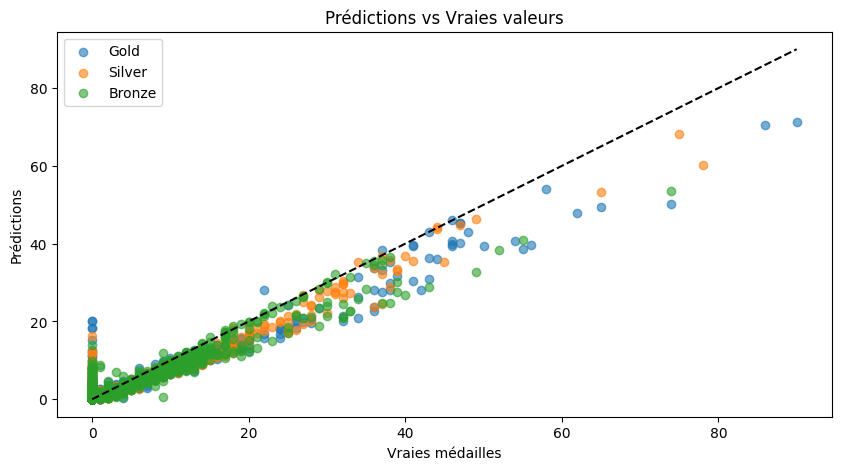

In [23]:
# ----------------------------
# Visualiser les prédictions vs vraies valeurs
plt.figure(figsize=(10,5))
plt.scatter(y_true_gold, y_pred_gold, label='Gold', alpha=0.6)
plt.scatter(y_true_silver, y_pred_silver, label='Silver', alpha=0.6)
plt.scatter(y_true_bronze, y_pred_bronze, label='Bronze', alpha=0.6)
plt.plot([0, max(y_true_gold.max(), y_pred_gold.max())],
         [0, max(y_true_gold.max(), y_pred_gold.max())], 'k--')
plt.xlabel("Vraies médailles")
plt.ylabel("Prédictions")
plt.title("Prédictions vs Vraies valeurs")
plt.legend()
plt.show()

**Sauvegarder ton modèle entraîné**

In [26]:
joblib.dump(rf_gold, "rf_gold.pkl")
joblib.dump(rf_silver, "rf_silver.pkl")
joblib.dump(rf_bronze, "rf_bronze.pkl")

['rf_bronze.pkl']